In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pandasql import sqldf
from kneed import KneeLocator
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, chi2
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

warnings.filterwarnings('ignore')

In [ ]:
health_data = pd.read_csv('../b. Datasets/NHANES/NHANES.csv')
data_dictionary = pd.read_excel('../b. Datasets/NHANES/Data Dictionary.xlsx')

In [3]:
display(health_data.head(2))
display(health_data.tail(2))

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25
0,73557,8,2,1,69,NaN,4,4,1,NaN,...,1.470207,4.864849,3.636711,-9.174492,-9.353410,5.153847,1.294983,-1.015693,-8.671692,5.423061
1,73558,8,2,1,54,NaN,3,3,1,NaN,...,-7.363791,-2.566326,0.776046,-2.951925,-0.538597,3.770290,6.711471,3.521875,-1.765809,-5.383746


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25
9811,83730,8,2,1,7,NaN,2,2,1,84.0,...,-6.364351,6.946665,6.685305,-0.735745,-5.504608,-9.899777,0.805068,0.186107,-9.070253,1.389257
9812,83731,8,2,1,11,NaN,5,6,1,140.0,...,2.901265,-6.967187,-2.400254,8.354035,-9.206879,-1.423042,5.206648,-1.364730,-6.213417,6.932066


In [4]:
display(data_dictionary.head(2))
display(data_dictionary.tail(2))

,Variable Name,Variable Description,Data File Name,Data File Description,Begin Year,EndYear,Component,Use Constraints
0,SEQN,Respondent sequence number.,DEMO_H,Demographic Variables and Sample Weights,2013,2014,Demographics,NaN
1,SDDSRVYR,Data release cycle,DEMO_H,Demographic Variables and Sample Weights,2013,2014,Demographics,NaN


,Variable Name,Variable Description,Data File Name,Data File Description,Begin Year,EndYear,Component,Use Constraints
634,LBDB12,Vitamin B12(pg/mL),VITB12_H,Vitamin B12,2013,2014,Laboratory,NaN
635,LBDB12SI,Vitamin B12 (pmol/L),VITB12_H,Vitamin B12,2013,2014,Laboratory,NaN


In [5]:
health_data.shape

(9813, 662)

In [6]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 662 entries, SEQN to ar25
dtypes: float64(641), int64(21)
memory usage: 49.6 MB


In [7]:
health_data.describe()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25
count,9813.000000,9813.0,9813.0,9813.000000,9813.000000,642.000000,9813.000000,9813.000000,9813.000000,4213.000000,...,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000
mean,78644.559971,8.0,2.0,1.507694,31.629573,10.258567,3.083766,3.277897,1.508509,107.478519,...,-1.868362,-3.024976,0.103960,1.732914,-2.639643,0.516211,0.847771,0.436837,-2.754273,2.018194
std,2938.592266,0.0,0.0,0.499966,24.397553,6.815038,1.262812,1.607957,0.499953,69.774776,...,5.689419,5.572118,5.621485,4.612798,7.025533,5.099966,7.074776,5.891879,5.608956,4.114095
min,73557.000000,8.0,2.0,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,-9.932773,-9.742275,-9.504686,-9.936065,-9.915099,-9.905405,-9.646950,-9.329935,-9.574369,-9.877965
25%,76092.000000,8.0,2.0,1.000000,10.000000,5.000000,2.000000,2.000000,1.000000,45.000000,...,-7.164033,-8.291340,-6.029267,-1.014871,-9.200133,-2.849344,-8.087627,-6.434927,-7.405031,-0.326282
50%,78643.000000,8.0,2.0,2.000000,27.000000,9.000000,3.000000,3.000000,2.000000,103.000000,...,-3.237602,-4.672666,0.173614,1.830624,-5.338621,1.884456,0.814447,-0.763828,-4.263325,1.885457
75%,81191.000000,8.0,2.0,2.000000,52.000000,16.000000,4.000000,4.000000,2.000000,166.000000,...,1.883083,2.533461,5.417423,4.025792,1.521804,5.003854,8.079576,7.174353,1.071647,4.904403
max,83731.000000,8.0,2.0,2.000000,80.000000,24.000000,5.000000,7.000000,2.000000,239.000000,...,9.984094,10.010548,9.933308,9.580645,9.837051,9.202594,9.679657,8.967017,9.944636,8.362119


In [8]:
features_with_null_values = health_data.columns[health_data.isna().any()].tolist()
print(f"Number of features with null values is {len(features_with_null_values)}.")

Number of features with null values is 613.


In [9]:
health_data.fillna(0, inplace=True)

In [10]:
health_data.isna().sum().sum()

0

In [11]:
standard_deviation_values = health_data.std()
display(standard_deviation_values.head(2))
display(standard_deviation_values.tail(2))

SEQN        2938.592266
SDDSRVYR       0.000000
dtype: float64

ar24    5.608956
ar25    4.114095
dtype: float64

In [12]:
count_of_features_dropped = 0
for feature, standard_dev in standard_deviation_values.items():
    if standard_dev == 0:
        health_data.drop(labels=feature, axis=1, inplace=True)
        count_of_features_dropped += 1
print(f"Count of features dropped due to 0 variance is {count_of_features_dropped}.")
print("These features are constant across the observations and don't provide any information that will aid the clustering process.")

Count of features dropped due to 0 variance is 9.
These features are constant across the observations and don't provide any information that will aid the clustering process.


In [13]:
health_data.clip(0.05, 0.95, inplace=True)

In [14]:
min_max_scaler = MinMaxScaler()
feature_names = health_data.columns
health_data = min_max_scaler.fit_transform(health_data)
health_data = pd.DataFrame(health_data, columns=feature_names)

In [15]:
display(health_data.head(2))
display(health_data.tail(2))

,SEQN,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,...,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.806718,0.0,0.0,1.0,1.0,1.0,0.0,0.0


,SEQN,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,...,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25
9811,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.838964,0.15123,0.0,1.0
9812,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.00000,0.0,1.0


In [16]:
X = health_data

## Implementing K-Means Clustering to gain better understanding of the data.

In [17]:
inertia = []
for n in range (1, 16):
    k_means_model = KMeans(n_clusters=n, 
                           init='k-means++', 
                           n_init=30, 
                           max_iter=300, 
                           tol=0.0001, 
                           random_state=0,
                           algorithm='elkan')
    k_means_model.fit(X)
    inertia.append(k_means_model.inertia_)
print("Within Cluster Sum of Squares (i.e Intertia) is:", inertia)

Within Cluster Sum of Squares (i.e Intertia) is: [888296.9749943637, 691761.6341821245, 621580.0871475916, 555528.4592400775, 512895.43686160876, 486305.8595795967, 464544.659437262, 443910.9070338828, 425402.61378500797, 408933.5734686017, 391352.2610945711, 383065.4707561362, 373249.63640473527, 363811.1243875767, 357103.5878584613]


In [18]:
n_clusters_range = range(1, len(inertia) + 1)
kneedle = KneeLocator(n_clusters_range, inertia, curve="convex", direction="decreasing")
optimal_clusters = kneedle.elbow
print(f"The optimum number of clusters (by elbow method) is {optimal_clusters}.")

The optimum number of clusters (by elbow method) is 5.


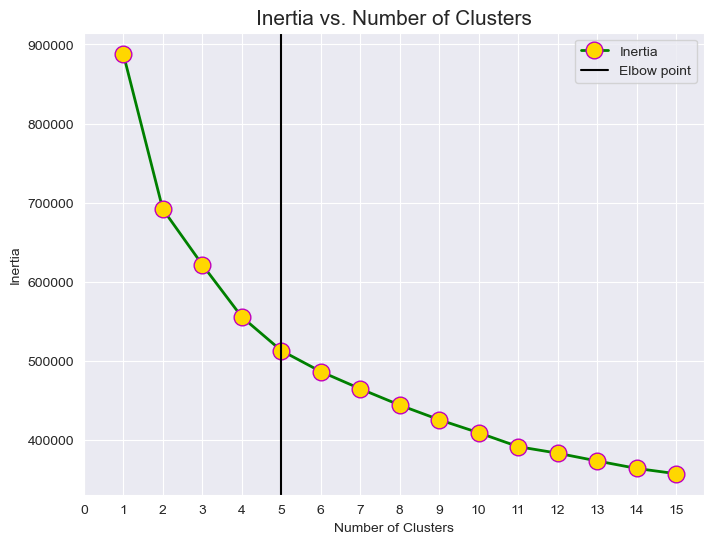

In [19]:
plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
plt.plot(list(range(1, 16)), 
         inertia, 
         linewidth=2, 
         markersize=12, 
         color='green', 
         marker='o', 
         markerfacecolor='gold', 
         markeredgecolor='m', 
         label='Inertia')

plt.axvline(x=5, color='black', label='Elbow point')

plt.xlabel('Number of Clusters', fontsize=10)
plt.ylabel('Inertia', fontsize=10)
plt.xticks(range(0, 16, 1))
plt.title('Inertia vs. Number of Clusters', fontsize=15)
plt.legend()
plt.show()

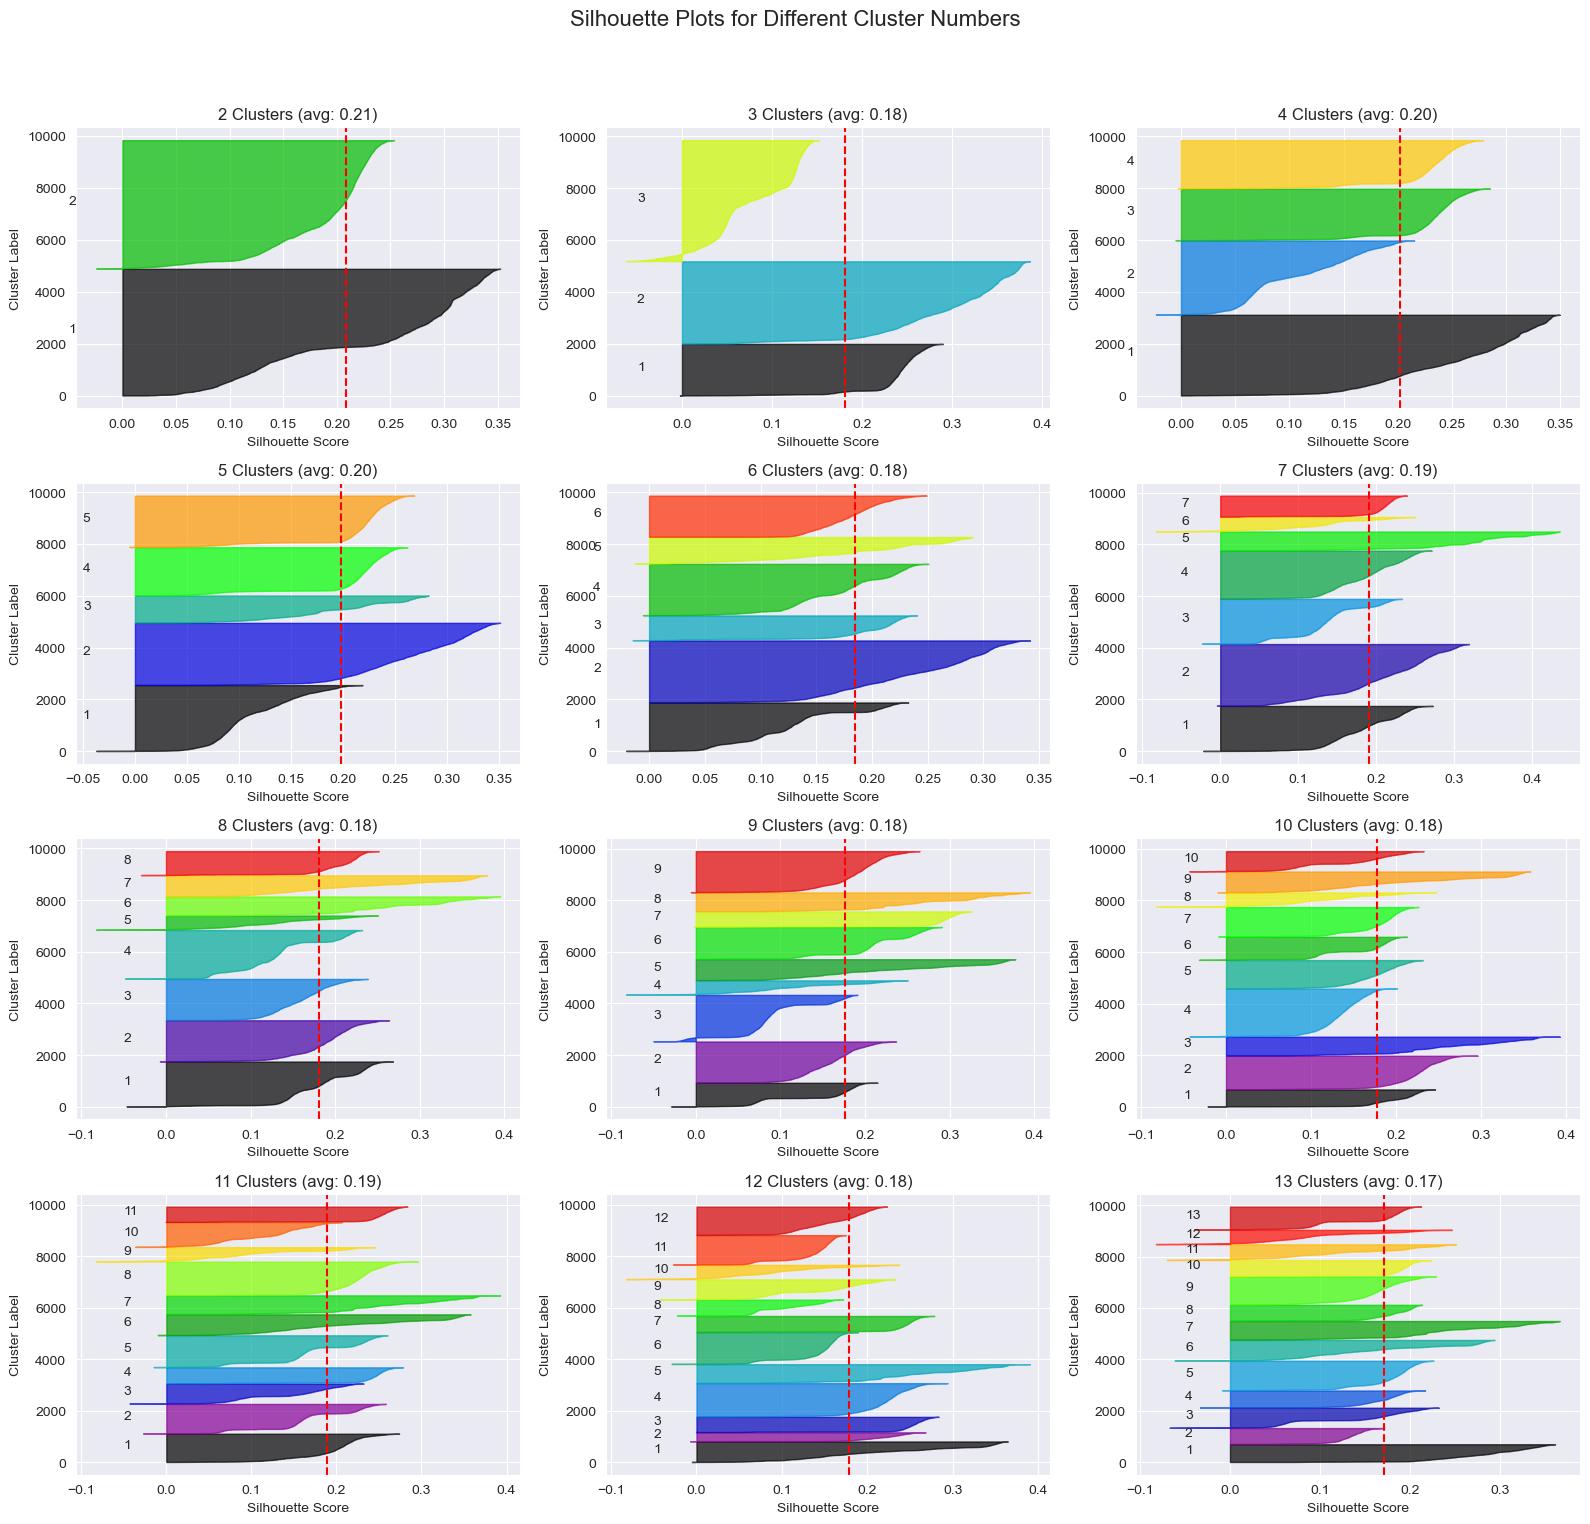

In [20]:
range_n_clusters = range(2, 14)

n_rows = 4
n_cols = 3

sns.set_style('darkgrid')
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))
fig.suptitle("Silhouette Plots for Different Cluster Numbers", fontsize=16)

for idx, n_clusters in enumerate(range_n_clusters):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    model = KMeans(n_clusters=n_clusters,
                   init='k-means++', 
                   n_init=30, 
                   max_iter=200, 
                   tol=0.0001, 
                   random_state=0,
                   algorithm='elkan')
    cluster_labels = model.fit_predict(X)

    # Compute silhouette score and sample silhouette values
    average_silhouette_score = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10

    for i in range(n_clusters):
        # Aggregate and sort silhouette scores for samples in each cluster
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Choose a colour for each cluster
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label each cluster plot
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))
        y_lower = y_upper + 10

    ax.axvline(x=average_silhouette_score, color="red", linestyle="--")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster Label")
    ax.set_title(f"{n_clusters} Clusters (avg: {average_silhouette_score:.2f})")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### Choosing optimum n_cluster value.
The elbow plot and the silhouette plot shows that the optimal number of cluster is 5. The elbow plot shows a noticeable bend at 5 clusters, indicating diminishing returns in reducing inertia [within-cluster sum of squares (WCSS)] beyond this point. 
The silhouette plot further confirms this selection, as the silhouette score was maximised for 5 clusters, signifying well-separated and cohesive clusters.

This analysis ensures that the clustering model achieves a balance between accuracy and simplicity, providing meaningful insights for the dataset.

In [21]:
optimum_n_clusters = 5

In [22]:
k_means_model = KMeans(n_clusters=optimum_n_clusters,
                       init='k-means++', 
                       n_init=30, 
                       max_iter=200, 
                       tol=0.0001, 
                       random_state=0,
                       algorithm='elkan')
cluster_labels = k_means_model.fit_predict(X)

In [23]:
health_data['Cluster'] = cluster_labels
health_data.head(2)

,SEQN,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,...,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25,Cluster
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.806718,0.0,0.0,1.0,1.0,1.0,0.0,0.0,3


In [24]:
continuous_features = health_data.select_dtypes(include=[np.number]).columns.drop('Cluster')

anova_results = f_classif(health_data[continuous_features], health_data['Cluster'])
anova_df = pd.DataFrame({
    'Feature': continuous_features,
    'ANOVA_F_value': anova_results[0],
    'p_value': anova_results[1]
}).sort_values(by='ANOVA_F_value', ascending=False)
display(anova_df.head(2))
display(anova_df.tail(2))

,Feature,ANOVA_F_value,p_value
464,LBDR84.y,279702.39703,0.0
436,LBDR33.y,279702.39703,0.0


,Feature,ANOVA_F_value,p_value
41,SDMVSTRA,NaN,NaN
47,DR1DRSTZ,NaN,NaN


In [25]:
anova_df = anova_df.dropna()
display(anova_df.head(2))
display(anova_df.tail(2))

,Feature,ANOVA_F_value,p_value
464,LBDR84.y,279702.39703,0.0
436,LBDR33.y,279702.39703,0.0


,Feature,ANOVA_F_value,p_value
499,URDP01LC,0.130132,0.971468
510,URDP25LC,0.094472,0.984245


In [26]:
features_having_impact_anova = sqldf('''
                                        select *
                                        from anova_df
                                        where p_value < 0.05
                                        and ANOVA_F_value > 1
                                        ''')
display(features_having_impact_anova.head(2))
display(features_having_impact_anova.tail(2))
print("According to Anova, the features that likely have some impact on the clustering \n", 
      features_having_impact_anova.Feature, end='')

,Feature,ANOVA_F_value,p_value
0,LBDR84.y,279702.39703,0.0
1,LBDR33.y,279702.39703,0.0


,Feature,ANOVA_F_value,p_value
601,FIAINTRP,2.434201,0.045174
602,FIAPROXY,2.434201,0.045174


According to Anova, the features that likely have some impact on the clustering 
 0      LBDR84.y
1      LBDR33.y
2      LBDR53.y
3      LBDR52.y
4      LBDR51.y
         ...   
598     DRQSDT4
599    INDFMIN2
600     FIALANG
601    FIAINTRP
602    FIAPROXY
Name: Feature, Length: 603, dtype: object

### What do ANOVA_F_value and p_value signify?
1. ANOVA_F_value:

    - This is the F-statistic for each feature, derived from an ANOVA (Analysis of Variance) test.
    - The F-statistic measures the degree of separation between the clusters based on each feature.
    - A higher F-value indicates that the mean values of the feature vary significantly across the clusters, suggesting a stronger correlation between that feature and the cluster labels.
  
2. p_value:

    - The p-value assesses the statistical significance of the F-statistic.
    - A low p-value (typically < 0.05) indicates that the differences in the feature’s mean values across clusters are statistically significant, implying that the feature is likely relevant to the clustering.
    - A high p-value suggests that the observed differences could be due to chance, implying the feature may not significantly correlate with the cluster labels.

### Interpretation
- High F-value and low p-value: The feature is likely to be important in differentiating clusters.
- Low F-value and high p-value: The feature likely does not significantly contribute to distinguishing between clusters.

In [27]:
discretizer = KBinsDiscretizer(n_bins=optimum_n_clusters, encode='ordinal', strategy='uniform')
binned_features = discretizer.fit_transform(health_data[continuous_features])
chi2_scores = chi2(binned_features, health_data['Cluster'])
chi2_df = pd.DataFrame({
    'Feature': continuous_features,
    'Chi2_Score': chi2_scores[0],
    'p_value': chi2_scores[1]
}).sort_values(by='Chi2_Score', ascending=False)
display(chi2_df.head(2))
display(chi2_df.tail(2))

,Feature,Chi2_Score,p_value
397,LBDR39.x,31469.331578,0.0
424,LBDR89.x,31469.331578,0.0


,Feature,Chi2_Score,p_value
41,SDMVSTRA,NaN,NaN
47,DR1DRSTZ,NaN,NaN


In [28]:
chi2_df.dropna(inplace=True)
display(chi2_df.head(2))
display(chi2_df.tail(2))
chi2_df.shape

,Feature,Chi2_Score,p_value
397,LBDR39.x,31469.331578,0.0
424,LBDR89.x,31469.331578,0.0


,Feature,Chi2_Score,p_value
18,SIAPROXY,0.003420,0.999999
11,DMDCITZN,0.000902,1.000000


(636, 3)

In [29]:
features_having_impact_chi2 = sqldf('''
                                    select *
                                    from chi2_df
                                    where Chi2_Score > 1
                                    and p_value < 0.05
                                    ''')

display(features_having_impact_chi2.head(2))
display(features_having_impact_chi2.tail(2))
print("According to Chi-Square, the features that likely have some impact on the clustering \n", 
      features_having_impact_chi2.Feature, end='')

,Feature,Chi2_Score,p_value
0,LBDR39.x,31469.331578,0.0
1,LBDR89.x,31469.331578,0.0


,Feature,Chi2_Score,p_value
618,URDP06LC,10.695831,0.030204
619,URDUCOLC,9.627810,0.047186


According to Chi-Square, the features that likely have some impact on the clustering 
 0      LBDR39.x
1      LBDR89.x
2      LBDR61.x
3      LBDR62.x
4      LBDR64.x
         ...   
615    URDUSRLC
616    URDCOPLC
617    URDUP8LC
618    URDP06LC
619    URDUCOLC
Name: Feature, Length: 620, dtype: object

### Chi-Square Test
- Chi2_Score: Measures the dependency between a feature and the cluster labels. A higher value indicates a stronger association between the feature and the cluster labels.
- p_value: Tests the statistical significance of the Chi2_Score. A low p-value (typically < 0.05) suggests that the feature is significantly associated with the cluster labels, meaning the relationship is unlikely to be due to random chance.

### Interpretation
High Chi2_Score and Low p-value: The feature is likely to be significantly associated with the cluster labels and contributes meaningfully to distinguishing between clusters.
Low Chi2_Score and High p-value: The feature likely has little to no significant association with the cluster labels and does not contribute substantially to cluster differentiation.

In [30]:
cluster_centroids = health_data.groupby('Cluster').mean()
correlation_with_centroids = health_data[continuous_features].corrwith(cluster_centroids.T.mean())
correlation_df = pd.DataFrame({
    'Feature': continuous_features,
    'Correlation_with_Centroids': correlation_with_centroids
}).sort_values(by='Correlation_with_Centroids', ascending=False)
display(correlation_df.head(2))
display(correlation_df.tail(2))

,Feature,Correlation_with_Centroids
ar9,ar9,0.951551
DR1TM201,DR1TM201,0.621900


,Feature,Correlation_with_Centroids
ar21,ar21,NaN
ar24,ar24,NaN


In [31]:
correlation_df.dropna(inplace=True)
display(correlation_df.head(2))
display(correlation_df.tail(2))
correlation_df.shape

,Feature,Correlation_with_Centroids
ar9,ar9,0.951551
DR1TM201,DR1TM201,0.621900


,Feature,Correlation_with_Centroids
LBXBCD,LBXBCD,-0.940236
ar23,ar23,-0.943218


(318, 2)

In [32]:
features_with_high_correlation_to_cluster_centroids = sqldf('''
                                                                select *
                                                                from correlation_df
                                                                where Correlation_with_Centroids > 0.6
                                                                or Correlation_with_Centroids < -0.6
                                                            ''')

display(features_with_high_correlation_to_cluster_centroids)
print("These features have a high correlation with the centroids of the clusters (both positive and negative).")

,Feature,Correlation_with_Centroids
0,ar9,0.951551
1,DR1TM201,0.621900
2,DR1TS120,-0.607399
3,DR1TS040,-0.611923
4,DR1TS100,-0.628471
5,DR1TS080,-0.682188
6,LBDMONO,-0.708695
7,LBDEONO,-0.717260
8,DRQSDT7,-0.738222
9,DRD350EQ,-0.738222


These features have a high correlation with the centroids of the clusters (both positive and negative).


### Correlation with Centroids
- Correlation_with_Centroids: Represents how strongly each feature is linearly related to the mean value (centroid) of the clusters.
- Values close to 1 or -1 indicate a strong positive or negative correlation, respectively.
- Values near 0 indicate weak or no correlation with the cluster centroids.

### Interpretation
- High Correlation (close to ±1): The feature is strongly associated with the cluster centroids and likely plays a significant role in defining cluster characteristics.
- Low Correlation (close to 0): The feature is weakly associated with the cluster centroids and is less likely to contribute meaningfully to cluster separation.

In [33]:
try:
    health_data.drop(labels="Cluster", axis=1, inplace=True)
except KeyError as ke:
    print("Already dropped the column.", ke)

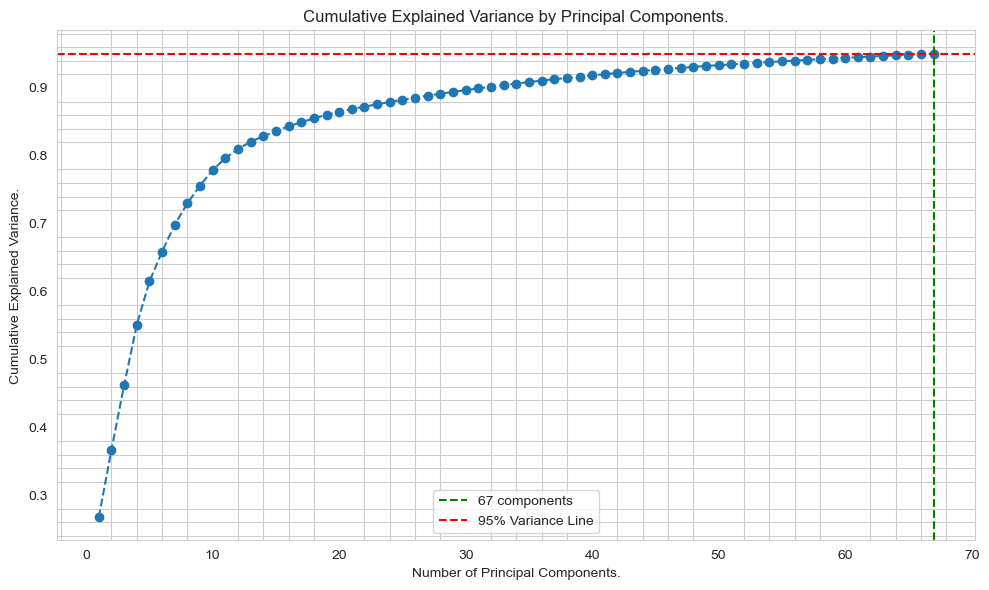

In [34]:
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(health_data)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_variance >= 0.95) + 1

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.axvline(x=num_components, color='green', linestyle='--', label=f'{num_components} components')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance Line')
plt.title('Cumulative Explained Variance by Principal Components.')
plt.xlabel('Number of Principal Components.')
plt.ylabel('Cumulative Explained Variance.')
plt.minorticks_on()
plt.grid(which='both')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
print(f"Number of principal components to retain (95% variance): {len(explained_variance_ratio)}")

print("\nExplained Variance Ratio per Component:")
print(explained_variance_ratio)

Number of principal components to retain (95% variance): 67

Explained Variance Ratio per Component:
[0.26784621 0.09899379 0.09519795 0.0889256  0.06399381 0.04379358
 0.0398557  0.03133556 0.02629201 0.02278808 0.01759276 0.01355034
 0.01063993 0.00804761 0.00759604 0.00705465 0.00608214 0.00567024
 0.00515824 0.00447632 0.0040243  0.00358617 0.00347312 0.00343484
 0.00319653 0.00314972 0.00295315 0.00283256 0.00273004 0.00255363
 0.00252458 0.00250194 0.00240726 0.0022696  0.00221361 0.00213248
 0.00206112 0.00194609 0.0019052  0.00182364 0.0017561  0.00171523
 0.00166035 0.00156475 0.00152557 0.00147332 0.00140366 0.00133738
 0.00132165 0.00122452 0.00119409 0.00116643 0.00115199 0.0011064
 0.00108978 0.00107342 0.00104235 0.0010179  0.00098432 0.00096246
 0.00095673 0.00094491 0.00091122 0.00089642 0.00088757 0.00086078
 0.00083837]


In [36]:
top_features = [health_data.columns[np.abs(pca.components_[i]).argsort()[::-1][:num_components]] for i in range(num_components)][0]
print(f"The features that are contributing to 95% of the variance in the data are:\n{top_features}")

The features that are contributing to 95% of the variance in the data are:
Index(['ORXH35', 'ORXH33', 'ORXH31', 'ORXH26', 'ORXH18', 'ORXGH', 'ORXH11',
       'ORXH16', 'ORXH06', 'ORXGL', 'ORXH69', 'ORXH71', 'ORXH70', 'ORXH67',
       'ORXH68', 'ORXH73', 'ORXH72', 'ORXH82', 'ORXH81', 'ORXH83', 'ORXH84',
       'ORXHPC', 'ORXHPI', 'ORXHPV', 'ORXH58', 'ORXH51', 'ORXH53', 'ORXH54',
       'ORXH55', 'ORXH56', 'ORXH52', 'ORXH59', 'ORXH45', 'ORXH61', 'ORXH40',
       'ORXH42', 'ORXH39', 'ORXH66', 'ORXH64', 'ORXH62', 'DMQMILIZ',
       'LBDSGLSI', 'LBDSCRSI', 'LBXSCLSI', 'LBXSC3SI', 'LBXSBU', 'LBDSALSI',
       'LBXSAL', 'LBXSGL', 'LBXSOSSI', 'LBXSNASI', 'LBXSPH', 'LBXSGTSI',
       'LBXSAPSI', 'LBXSKSI', 'LBDSBUSI', 'LBDSCHSI', 'LBXSCH', 'LBDSUASI',
       'LBXSUA', 'LBXSATSI', 'LBXSASSI', 'LBXSLDSI', 'LBXSTR', 'LBDSTBSI',
       'LBDSGBSI', 'LBXSGB'],
      dtype='object')


In [37]:
X = health_data[top_features]
k_means_model = KMeans(n_clusters=optimum_n_clusters,
                       init='k-means++', 
                       n_init=30, 
                       max_iter=200, 
                       tol=0.0001, 
                       random_state=0,
                       algorithm='elkan')
cluster_labels = k_means_model.fit_predict(X)

In [38]:
health_data["Cluster"] = cluster_labels

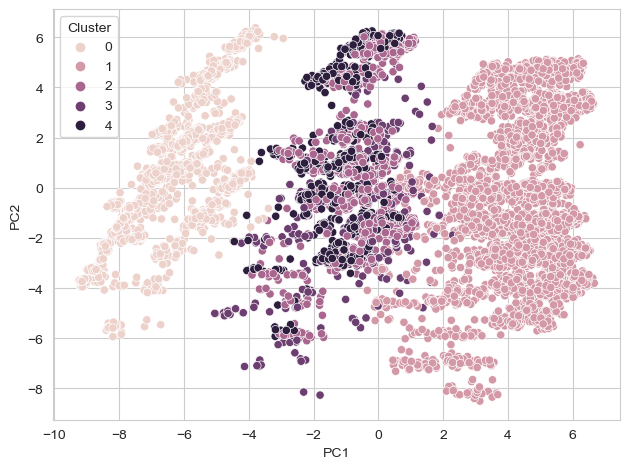

In [39]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(health_data)

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = health_data['Cluster']

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster")
plt.tight_layout()
plt.show()

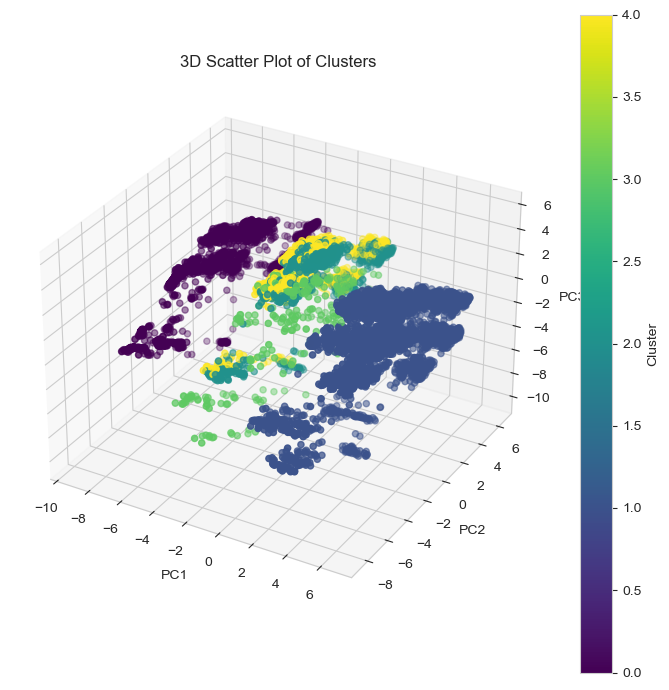

In [40]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(health_data)

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = health_data['Cluster']

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.colorbar(scatter, label='Cluster')
ax.set_title('3D Scatter Plot of Clusters')
plt.tight_layout()
plt.show()

In [41]:
try:
    health_data.drop(labels="Cluster", axis=1, inplace=True)
except KeyError as ke:
    print("Already dropped the column.", ke)

## Implementing DBScan to understand the breakdown by that method.

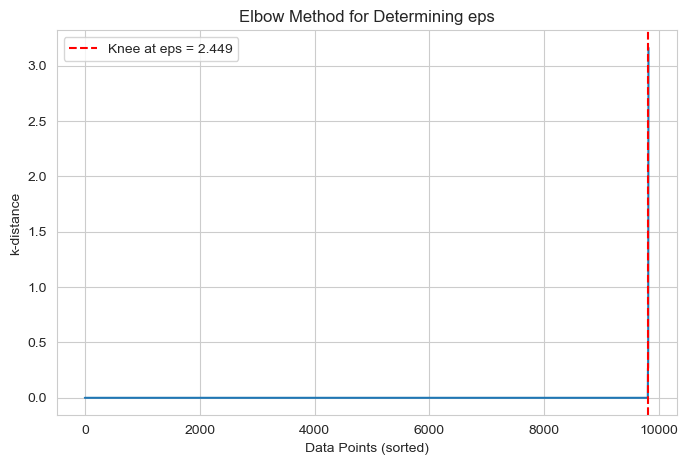

Optimal eps: 2.449489742783178


In [42]:
neighbours = NearestNeighbors(n_neighbors=optimum_n_clusters)
neighbours.fit(health_data[top_features])
distances, _ = neighbours.kneighbors(health_data[top_features])

# Sorting distances in ascending order
distances = np.sort(distances[:, -1])  # Sort the k-distance values (distance to kth nearest neighbour)

# Use KneeLocator to find the elbow
knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee_locator.knee]

# Plot the k-distance graph with the knee
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.axvline(x=knee_locator.knee, color='red', linestyle='--', label=f"Knee at eps = {optimal_eps:.3f}")
plt.xlabel('Data Points (sorted)')
plt.ylabel('k-distance')
plt.title('Elbow Method for Determining eps')
plt.legend()
plt.show()

print(f"Optimal eps: {optimal_eps}")

In [43]:
search_space = {
    'eps': Real(optimal_eps * 0.5, optimal_eps * 1.5),
    'min_samples': Integer(2, 15),
    'metric': Categorical(['euclidean', 'manhattan', 'cosine']),
    'leaf_size': Integer(20, 50)
}

def silhouette_scorer(estimator, X):
    '''
    Description: Computes the silhouette score as a custom scoring function for clustering models.
                 If the model identifies fewer than two clusters (e.g., all points assigned to one cluster or marked as noise),
                 the function returns -1 to indicate an invalid clustering result.
    '''
    labels = estimator.fit_predict(X)
    if len(set(labels)) <= 1:
        return -1  # Return a low score if only one cluster or all points are noise
    return silhouette_score(X, labels)

dbscan_model = DBSCAN()
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=0)

bayesian_optimisation = BayesSearchCV(estimator=dbscan_model,
                                        search_spaces=search_space,
                                        n_iter=15,
                                        scoring=silhouette_scorer,
                                        cv=kfold_cv,
                                        n_jobs=-1,
                                        random_state=0)

bayesian_optimisation.fit(health_data[top_features])
best_parameters = bayesian_optimisation.best_params_

print("Best parameters found:", best_parameters)
print("Best silhouette score:", bayesian_optimisation.best_score_)

Best parameters found: OrderedDict([('eps', 1.224744871391589), ('leaf_size', 50), ('metric', 'euclidean'), ('min_samples', 2)])
Best silhouette score: 0.9797455620443932


In [44]:
optimal_dbscan = DBSCAN(eps=best_parameters['eps'],
                        min_samples=best_parameters['min_samples'],
                        metric=best_parameters['metric'],
                        leaf_size=best_parameters['leaf_size'])

cluster_labels = optimal_dbscan.fit_predict(health_data[top_features])
print(f"Total number of clusters: {np.unique(cluster_labels)}")

Total number of clusters: [-1  0  1  2  3  4]


Cluster Labels (0, 1, 2, 3, 4): These represent the clusters identified by the DBSCAN algorithm. Points with these labels belong to their respective clusters.
For example:

- Points labelled 0 belong to Cluster 0.
- Points labelled 1 belong to Cluster 1, and so on.
- Noise Points (-1): Points with the label -1 are considered noise or outliers. These points do not belong to any cluster as they do not satisfy the eps and min_samples criteria of DBSCAN.

In [45]:
health_data['Cluster'] = cluster_labels

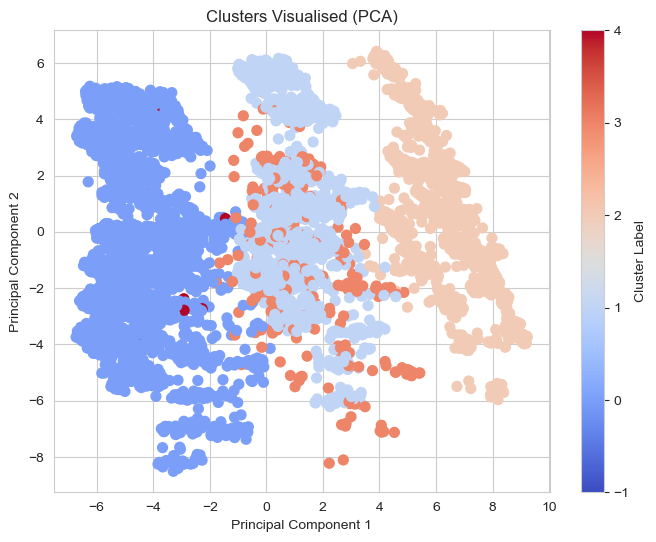

In [46]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(health_data)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='coolwarm', s=50)
plt.colorbar(label='Cluster Label')
plt.title('Clusters Visualised (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

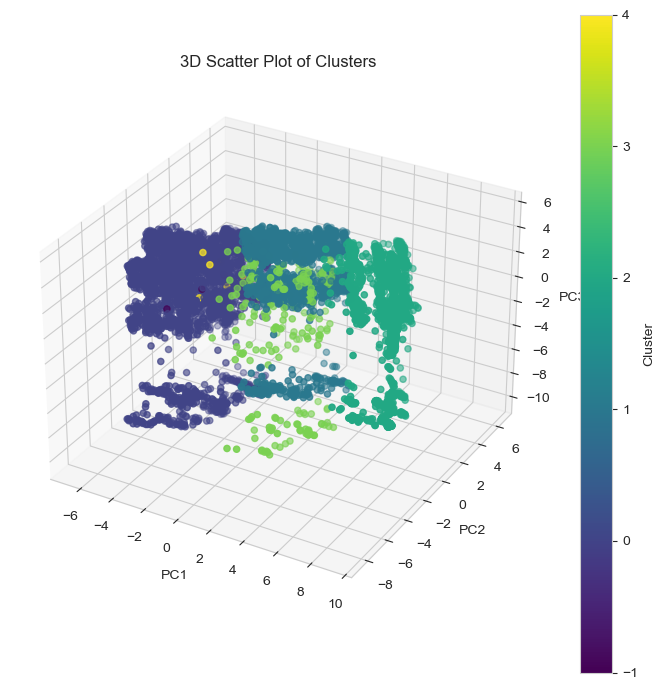

In [47]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(health_data)

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = health_data['Cluster']

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.colorbar(scatter, label='Cluster')
ax.set_title('3D Scatter Plot of Clusters')
plt.tight_layout()
plt.show()

t-SNE (t-Distributed Stochastic Neighbour Embedding) is a machine learning algorithm used for dimensionality reduction and visualisation of high-dimensional data in 2 or 3 dimensions.

Key Features:
- Non-linear Dimensionality Reduction: t-SNE focuses on preserving the local structure of data, meaning similar data points in high dimensions are likely to stay close in the reduced space.
- Visualisation: Commonly used to visualise clusters or patterns in datasets with high-dimensional features, such as images, text embeddings, or gene expression data.

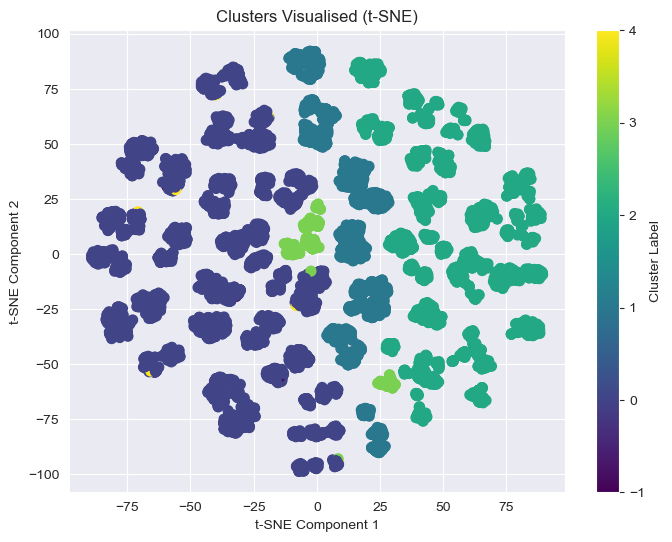

In [48]:
tsne = TSNE(n_components=2, random_state=0)
reduced_data = tsne.fit_transform(health_data)

plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title('Clusters Visualised (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [49]:
submission_dataframe = pd.DataFrame({
    'Index': health_data.index,
    'Cluster': cluster_labels
})
submission_dataframe.sort_values(by="Index", inplace=True)
display(submission_dataframe.head(2))
display(submission_dataframe.tail(2))

,Index,Cluster
0,0,0
1,1,0


,Index,Cluster
9811,9811,2
9812,9812,2


In [ ]:
submission_dataframe_file = ('../d. Output Files/NHANES/' +'HealthData_ClusterPrediction.csv')
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: HealthData_ClusterPrediction.csv


##### Silhouette Score Range:

- -1: Points are assigned to the wrong clusters.
- 0: Points are on or near the boundary between clusters.
- +1: Points are well inside their assigned clusters, far from neighbouring clusters.

##### Interpretation:

- A score of 0.9797 is close to 1, suggesting:
    - The clusters are compact and well-separated.
    - Most data points are closer to their own cluster centre than to the centres of other clusters.

# Overview

## 1. Project Objective
The goal of this project was to perform unsupervised clustering on the health_data dataset to uncover natural groupings or patterns without relying on predefined labels. The analysis aimed to identify the most influential features, determine optimal clustering parameters, and evaluate the effectiveness of clustering techniques such as KMeans and DBSCAN.

## 2. Data Preparation
### 2.1 File Reading:
- Loaded the data from ML3 data.csv and the data dictionary from Data_Description.xlsx to understand the features and structure.

### 2.2 Data Cleanup:
- Handled missing values by removing NANs to ensure clean data.
- Checked and addressed feature skewness to improve model performance.
- Applied Winsorisation to reduce the impact of outliers.
- Normalised data using Min-Max Scaling to ensure features were on the same scale and avoid any feature dominating the clustering process.

## 3. Initial Clustering (KMeans)
### 3.1 Within Cluster Sum of Squares (WCSS):
- Calculated WCSS (inertia) for different cluster numbers to evaluate the compactness of clusters formed by KMeans.

### 3.2 Elbow Method:
- Utilised the KneeLocator to determine the optimal number of clusters by finding the "elbow" in the WCSS curve, which provides the best trade-off between model complexity and performance.

### 3.3 Silhouette Plots:
- Visualised cluster quality with silhouette plots, which revealed how well each data point fit within its assigned cluster.

### 3.4 KMeans with Optimal Clusters:
- Built the KMeans model with the optimal number of clusters as determined by the elbow method and evaluated its clustering performance.

## 4. Feature Significance Analysis
### 4.1 ANOVA for Feature Selection:
- Conducted ANOVA tests to identify features with significant differences across the cluster labels.
- Focused on features with high F-values and low p-values to retain the most important variables for clustering.

## 5. Dimensionality Reduction
### 5.1 PCA (Principal Component Analysis):
- To deal with the high dimensionality of the data, PCA was applied to reduce the number of features while retaining 95% of the variance.
- This helped in simplifying the data without losing critical information, ensuring that subsequent clustering was more efficient and effective.

## 6. Advanced Clustering (DBSCAN)
### 6.1 DBSCAN (Density-Based Spatial Clustering of Applications with Noise):
- Applied DBSCAN, a density-based clustering algorithm, to find arbitrarily shaped clusters and detect noise points.

### 6.2 Hyperparameter Tuning with Bayesian Optimisation:
- Performed Bayesian Optimisation to tune DBSCAN’s hyperparameters:
- eps: Distance parameter that determines the maximum radius for points to be considered neighbours.
- min_samples: Minimum number of samples required to form a cluster.
- Other parameters such as metric and leaf_size were also tuned for optimal performance.

### 6.3 Silhouette Score:
- The hyperparameter tuning process aimed to maximise the silhouette score.
- A silhouette score of 0.9797 was achieved, indicating that the clusters formed by DBSCAN were well-separated and compact.

## 7. Clustering Results
### 7.1 Cluster Quality:

- Both KMeans and DBSCAN produced strong cluster results, with DBSCAN demonstrating superior performance as evidenced by the high silhouette score.
- Clusters were well-separated, and there were only a few noise points in DBSCAN, suggesting that the chosen eps and min_samples values were optimal.

### 7.2 Feature Importance:
- The selected features, identified through ANOVA, Chi-Square and Correlation and PCA, were critical for determining cluster membership. These features - highlighted significant differences between clusters.

## 8. Key Findings
### 8.1 Effective Clustering:
- Both KMeans and DBSCAN identified meaningful clusters in the data.
- The silhouette score of 0.9797 confirmed that the DBSCAN model formed well-defined clusters, with high intra-cluster cohesion and distinct separation between clusters.

### 8.2 Dimensionality Reduction:
- PCA successfully reduced the dimensionality of the dataset, retaining 95% of the variance while simplifying the data, which contributed to better clustering results.

### 8.3 Feature Selection:
- Features with significant statistical differences (as determined by ANOVA, Chi-Square and Correlation) were crucial for effective clustering.
- Using PCA, irrelevant or redundant features were eliminated, focusing only on the most impactful features.

### 8.4 Hyperparameter Tuning:
- Bayesian Optimisation for DBSCAN hyperparameters (eps, min_samples, metric, and leaf_size) was crucial in obtaining the best clustering results.
- The tuned DBSCAN model outperformed KMeans in terms of cluster quality, as indicated by the silhouette score.

## Conclusion
The project successfully implemented an unsupervised learning pipeline to identify meaningful clusters in a complex health dataset. Through data preparation, dimensionality reduction, and advanced clustering techniques like KMeans and DBSCAN, you uncovered distinct patterns in the data. The high silhouette score indicates that the clusters are of high quality, with a clear separation between groups. The findings can now serve as a basis for further analysis, profiling, or practical application in the health domain.